# Image Tampering detection workbook

In this workbook, we're going to look at the "copy-move" image forgery and our dataset comes from here:
http://lci.micc.unifi.it/labd/2015/01/copy-move-forgery-detection-and-localization/


First, you should go to the website and download MICC-F220. It is the smallest of the datasets available here.



Now here are the imports for the packages we are going to use. 
Make sure they all import and use !pip install to install any you need.

In [1]:
#import libraries 
import os
import cv2
import matplotlib.pyplot as plt
import keras
import numpy as np
import shutil
from random import randrange
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

%matplotlib inline

Next, we're going to process our downloaded dataset so that the file/folder structure is convenient to use.

In [2]:
image_paths=[] #List to store path of all images

# First, we just want images.
for dirname, _, filenames in os.walk('MICC-F220/'):
    for filename in filenames:
        if '.txt' in filename: # in some datasets, you might need to filter specifically for jpg or png
            continue
        image_paths.append(os.path.join(dirname, filename))

        
# Check to see that you've got some image names

In [3]:
original_images=[]
tampered_images=[]

for path in image_paths:
    
    if 'tamp' in path:              # As Observed from the above list tampered images name has tamp
        tampered_images.append(path)
    else:
        original_images.append(path)
tampered_images.sort()
original_images.sort()
print(len(original_images),len(tampered_images))

110 110


In [4]:

# Now create directories and move the files.
os.mkdir("MICC-F220_sorted")
os.mkdir("MICC-F220_sorted/test")
os.mkdir("MICC-F220_sorted/train")

testset1in = 10 #1 in 10 chance of file going in to test set

mytestdirname = "MICC-F220_sorted/test/original"
os.mkdir(mytestdirname)
mytraindirname = "MICC-F220_sorted/train/original"
os.mkdir(mytraindirname)

for filename in original_images:
    f = os.path.basename(filename)
    mydirname = mytraindirname
    if randrange(testset1in) == 1:
        mydirname = mytestdirname
    dst = os.path.join(mydirname, f)
    shutil.copy2(filename, dst)
    
mytestdirname = "MICC-F220_sorted/test/tampered"
os.mkdir(mytestdirname)
mytraindirname = "MICC-F220_sorted/train/tampered"
os.mkdir(mytraindirname)

for filename in tampered_images:
    f = os.path.basename(filename)
    mydirname = mytraindirname
    if randrange(testset1in) == 1:
        mydirname = mytestdirname

    dst = os.path.join(mydirname, f)
    shutil.copy2(filename, dst)

Now let's look at some images...

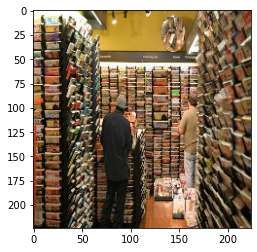

In [5]:
im = cv2.imread('MICC-F220_sorted/train/tampered/CRW_4853tamp1.jpg')
im_resized = cv2.resize(im, (224, 224), interpolation=cv2.INTER_LINEAR)
plt.imshow(cv2.cvtColor(im_resized, cv2.COLOR_BGR2RGB)) # remember the colour convert
plt.show()


Now we want a basic binary classification model, just operating directly on the pixels.

In [6]:
# define cnn model
def define_model():
    model = keras.Sequential()
    model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(200, 200, 3), name="layer1"))
    model.add(keras.layers.MaxPooling2D((2, 2)))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(keras.layers.Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer="sgd", metrics=['accuracy'])
    return model

In [7]:
# create data generator
datagen = ImageDataGenerator(rescale=1.0/255.0)
# prepare iterators
train_it = datagen.flow_from_directory('MICC-F220_sorted/train/', class_mode='binary', batch_size=64, target_size=(200, 200))
test_it = datagen.flow_from_directory('MICC-F220_sorted/test/', class_mode='binary', batch_size=64, target_size=(200, 200))

Found 197 images belonging to 2 classes.
Found 23 images belonging to 2 classes.


In [8]:
# define model
model = define_model()
history = model.fit(train_it, steps_per_epoch=len(train_it), validation_data=test_it, validation_steps=len(test_it), epochs=20)

Epoch 1/20
4/4 [==============================] - 6s 1s/step - loss: 2.9702 - accuracy: 0.4721 - val_loss: 0.9288 - val_accuracy: 0.5217
Epoch 2/20
4/4 [==============================] - 4s 879ms/step - loss: 0.7640 - accuracy: 0.5685 - val_loss: 0.8917 - val_accuracy: 0.4783
Epoch 3/20
4/4 [==============================] - 4s 875ms/step - loss: 0.7114 - accuracy: 0.5178 - val_loss: 1.8015 - val_accuracy: 0.4783
Epoch 4/20
4/4 [==============================] - 4s 982ms/step - loss: 0.9540 - accuracy: 0.5025 - val_loss: 0.6844 - val_accuracy: 0.5217
Epoch 5/20
4/4 [==============================] - 4s 1s/step - loss: 0.6984 - accuracy: 0.5025 - val_loss: 0.6904 - val_accuracy: 0.5217
Epoch 6/20
4/4 [==============================] - 4s 903ms/step - loss: 0.6811 - accuracy: 0.5736 - val_loss: 0.7086 - val_accuracy: 0.4783
Epoch 7/20
4/4 [==============================] - 4s 829ms/step - loss: 0.6579 - accuracy: 0.6091 - val_loss: 0.8507 - val_accuracy: 0.4783
Epoch 8/20
4/4 [==========

In [9]:
_, acc = model.evaluate_generator(test_it, steps=len(test_it), verbose=0)
print('> %.3f' % (acc * 100.0))

/Users/pam/opt/anaconda3/lib/python3.7/site-packages/keras/engine/training.py:2006: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


> 47.826


Ok, now you have a baseline. You can try changing the model architecture to try to improve your classification accuracy.
(hints:
You could change the optimizer to Adam, or change the learning rate or even...
 `model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))`
 adding another conv layer might be useful, although you might want to give it a name...
)

Lastly, we're going to look at interpreting the model. We're going to use GradCAM from here:
    https://keras.io/examples/vision/grad_cam/. GradCAM will generate a heatmap for a specific image showing the pixels that were important to the image.

In [10]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

Now have a look to see which image you're going to run this on. 
Maybe you want to pick a different image, one where you can absolutely see the image tampering.

What do you see? Does the neural network actually look at the tampered section of the image to detect tampering?

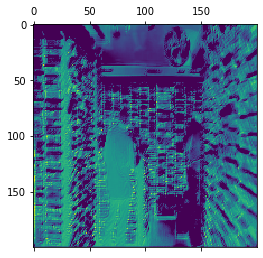

In [11]:
preprocess_input = keras.applications.xception.preprocess_input

img_path = 'MICC-F220_sorted/train/tampered/CRW_4853tamp1.jpg' # The same image as earlier...
last_conv_layer_name = 'layer1'
img_size = (200, 200)

# Prepare image
img_array = preprocess_input(get_img_array(img_path, size=img_size))

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

Does it look at the tampered section? Does it? Does it really?! 
Many early tampering-detection datasets were produced without proper respect for compression. 
It is possible that the dataset we have chose has fallen into this trap. 
Tampered images and authentic images have sometimes been compressed a different number of times.
If there is an easy way to do something, a neural network will pick it up!